
## Classification Using Decision Tree, Random Forest,  and Logistic Regression in Pyspark


## Table of Contents

* [Bank case study: Will the client subscribe?](#one)
* [Data Loading and Preparation](#data-preparation)
* [Feature Engineering](#feature-engineering)
    * [StringIndexer](#feature-engineering)
    * [OneHotEncoder](#feature-engineering)
    * [VectorAssembler](#feature-engineering)
* [Pipeline API](#pipeline)
* [Train/Test Split](#train-test)
* [ML Classification Models](#models)
    * [Decision Tree](#dt)
    * [Random Forest](#rf)        
    * [Logistic Regression](#lr)    
* [Model Evaluation](#model-evaluation)
    * [Confusion Matrix](#confusion-matrix)
    * [Area Under the Curve](#roc)    
    * [Visualizing ROC Curve](#roc-viz)


## Bank case study: Will the client subscribe? <a class="anchor" id="one"></a>
<hr/>

The data was used to direct marketing campaigns of a banking institution. The marketing campaigns were based on phone calls. The classification goal is to predict whether the client will subscribe (1/0) to a term deposit.

### **Attributes**

1. age (numeric)
2. job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3. marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4. education (categorical: 'primary', 'secondary', 'tertiary', 'unknown')
5. default: has credit in default? (categorical: 'no','yes','unknown')
6. balance : bank balance
7. housing: has housing loan? (categorical: 'no','yes','unknown')
8. loan: has personal loan? (categorical: 'no','yes','unknown')

### Related with the last contact of the current campaign:
9. contact: contact communication type (categorical: 'cellular','telephone','unknown')
10. day: last contact day of the week (numerical: 1,2,...28,29,30)
1. month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
12. duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

### Other attributes:
12. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14. previous: number of contacts performed before this campaign and for this client (numeric)
15. poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success','unknown')

### Output variable (desired target):
16. deposit - has the client subscribed a term deposit? (binary: 'yes','no')

In [34]:
# TODO: Import libraries needed from pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession # Spark SQL
# TODO: Create Spark Configuration Object
app_name = "Spark ML"
master = "local[*]"
spark_conf = SparkConf().setMaster(master).setAppName(app_name)
# TODO: Create SparkSession
spark = SparkSession.builder.config(conf=spark_conf).getOrCreate()
sc = spark.sparkContext
sc.setLogLevel('ERROR')

### Step 1: Data Loading and Preparation <a class="anchor" name="data-preparation"></a> 

In [35]:
#Write your code here
df_bank = spark.read.format('csv')\
            .option('header',True).option('escape','"')\
            .load('bank.csv')

In [36]:
df_bank.printSchema()

root
 |-- age: string (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: string (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: string (nullable = true)
 |-- campaign: string (nullable = true)
 |-- pdays: string (nullable = true)
 |-- previous: string (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



### Step 2: Feature Engineering <a class="anchor" name="feature-engineering"></a> 
 Using all the features, separate the numerical and non-numerical features to simplify the Feature Engineering process. For the <strong style="color:red"> target variable, make sure 1 is for Yes and 0 is for No</strong> while converting it to numeric representation.

In [37]:
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import StringIndexer
cols = ["job","marital","education","default","housing","loan","contact","month","poutcome","deposit"]
input_columns = [x for x in cols]
output_columns = [f'{x}_index' for x in input_columns]
indexer = StringIndexer(inputCols=input_columns, outputCols=output_columns)
df_bank = indexer.fit(df_bank).transform(df_bank)


In [38]:
df_bank.select(output_columns).show()

+---------+-------------+---------------+-------------+-------------+----------+-------------+-----------+--------------+-------------+
|job_index|marital_index|education_index|default_index|housing_index|loan_index|contact_index|month_index|poutcome_index|deposit_index|
+---------+-------------+---------------+-------------+-------------+----------+-------------+-----------+--------------+-------------+
|      3.0|          0.0|            0.0|          0.0|          1.0|       0.0|          1.0|        0.0|           0.0|          1.0|
|      3.0|          0.0|            0.0|          0.0|          0.0|       0.0|          1.0|        0.0|           0.0|          1.0|
|      2.0|          0.0|            0.0|          0.0|          1.0|       0.0|          1.0|        0.0|           0.0|          1.0|
|      4.0|          0.0|            0.0|          0.0|          1.0|       0.0|          1.0|        0.0|           0.0|          1.0|
|      3.0|          0.0|            1.0|       

In [39]:
remaining_cols = list()
for x in df_bank.columns:
    if x in cols:
        continue
    remaining_cols.append(x)

In [40]:
print(remaining_cols)

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous', 'default_index', 'poutcome_index', 'deposit_index', 'loan_index', 'housing_index', 'marital_index', 'month_index', 'contact_index', 'education_index', 'job_index']


In [41]:
from pyspark.sql.types import DoubleType
for x in remaining_cols:
    df_bank = df_bank.withColumn(x, df_bank[x].cast(DoubleType()))

In [42]:
df_bank.printSchema()

root
 |-- age: double (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: double (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: double (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: double (nullable = true)
 |-- campaign: double (nullable = true)
 |-- pdays: double (nullable = true)
 |-- previous: double (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)
 |-- default_index: double (nullable = false)
 |-- poutcome_index: double (nullable = false)
 |-- deposit_index: double (nullable = false)
 |-- loan_index: double (nullable = false)
 |-- housing_index: double (nullable = false)
 |-- marital_index: double (nullable = false)
 |-- month_index: double (nullable = false)
 |-- contact_index: double 

In [43]:
inputCols_OHE = [x for x in output_columns if x != 'deposit_index']
outputCols_OHE = [f'{x}_vec' for x in inputCols_OHE]

encoder = OneHotEncoder(inputCols=inputCols_OHE,
                        outputCols=outputCols_OHE)
# Call fit and transform to get the encoded results
df_bank = encoder.fit(df_bank).transform(df_bank)
#Display the output columns
df_bank.select(outputCols_OHE).show()

+--------------+-----------------+-------------------+-----------------+-----------------+--------------+-----------------+---------------+------------------+
| job_index_vec|marital_index_vec|education_index_vec|default_index_vec|housing_index_vec|loan_index_vec|contact_index_vec|month_index_vec|poutcome_index_vec|
+--------------+-----------------+-------------------+-----------------+-----------------+--------------+-----------------+---------------+------------------+
|(11,[3],[1.0])|    (2,[0],[1.0])|      (3,[0],[1.0])|    (1,[0],[1.0])|        (1,[],[])| (1,[0],[1.0])|    (2,[1],[1.0])| (11,[0],[1.0])|     (3,[0],[1.0])|
|(11,[3],[1.0])|    (2,[0],[1.0])|      (3,[0],[1.0])|    (1,[0],[1.0])|    (1,[0],[1.0])| (1,[0],[1.0])|    (2,[1],[1.0])| (11,[0],[1.0])|     (3,[0],[1.0])|
|(11,[2],[1.0])|    (2,[0],[1.0])|      (3,[0],[1.0])|    (1,[0],[1.0])|        (1,[],[])| (1,[0],[1.0])|    (2,[1],[1.0])| (11,[0],[1.0])|     (3,[0],[1.0])|
|(11,[4],[1.0])|    (2,[0],[1.0])|      (3,[0]

In [44]:
df_bank.printSchema()

root
 |-- age: double (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: double (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: double (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: double (nullable = true)
 |-- campaign: double (nullable = true)
 |-- pdays: double (nullable = true)
 |-- previous: double (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)
 |-- default_index: double (nullable = false)
 |-- poutcome_index: double (nullable = false)
 |-- deposit_index: double (nullable = false)
 |-- loan_index: double (nullable = false)
 |-- housing_index: double (nullable = false)
 |-- marital_index: double (nullable = false)
 |-- month_index: double (nullable = false)
 |-- contact_index: double 

In [45]:
df_bank = df_bank.withColumnRenamed('deposit_index','label')

In [46]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
inputCols= [x for x in outputCols_OHE]
for x in remaining_cols:
    if x == 'deposit_index':
        continue
    inputCols.append(x)
assembler = VectorAssembler(
    inputCols=inputCols,
    outputCol="features")
df_bank = assembler.transform(df_bank)
#Display the output
df_bank.select("features","label").show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|features                                                                                                                                           |label|
+---------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|(51,[3,11,13,16,18,20,21,32,35,36,37,38,39,40,45,48,50],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,59.0,2343.0,5.0,1042.0,1.0,-1.0,1.0,1.0,3.0])             |1.0  |
|(51,[3,11,13,16,17,18,20,21,32,35,36,37,38,39,40,48,50],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,56.0,45.0,5.0,1467.0,1.0,-1.0,1.0,3.0])               |1.0  |
|(51,[2,11,13,16,18,20,21,32,35,36,37,38,39,40,45,48,50],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,41.0,1270.0,5.0,1389.0,1.0,-1.0,1.0,1.0,2.0])             |1.0  |
|(51,[4,11,13,16,18,20,21,32,35,36,37,38,39,40,45,48,50],[1.0,1.

In [47]:
df_bank.printSchema()

root
 |-- age: double (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: double (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: double (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: double (nullable = true)
 |-- campaign: double (nullable = true)
 |-- pdays: double (nullable = true)
 |-- previous: double (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)
 |-- default_index: double (nullable = false)
 |-- poutcome_index: double (nullable = false)
 |-- label: double (nullable = false)
 |-- loan_index: double (nullable = false)
 |-- housing_index: double (nullable = false)
 |-- marital_index: double (nullable = false)
 |-- month_index: double (nullable = false)
 |-- contact_index: double (nullabl

In [48]:
train, test = df_bank.randomSplit([0.9, 0.1], seed=12345)

In [49]:
#Implementing the Logistic Regression
from pyspark.ml.classification import LogisticRegression

# Create a LogisticRegression instance. This instance is an Estimator.
lr = LogisticRegression(featuresCol='features',labelCol='label')
model = lr.fit(train)

In [50]:
predicted_data = model.transform(test)
predicted_data.select('features','label','prediction').filter(predicted_data.label==1).show(truncate = False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+----------+
|features                                                                                                                                                          |label|prediction|
+------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+----------+
|(51,[7,11,16,17,18,19,22,33,35,36,37,38,39,40,41,43,47,49,50],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,20.0,292.0,5.0,385.0,2.0,93.0,1.0,1.0,1.0,3.0,7.0])                |1.0  |1.0       |
|(51,[7,12,16,17,18,19,32,35,36,37,38,39,40,46,47,49,50],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,20.0,755.0,29.0,284.0,1.0,-1.0,1.0,11.0,3.0,7.0])                            |1.0  |1.0       |
|(51,[7,12,15,16,17,18,29,34,35,36,37,38,39,40,41,43,46,47,48,49,50],[1.0,1.0,1.0,1.0,1.0,

In [51]:
trainingSummary = model.summary
trainingSummary.accuracy

0.8266229247440103

# Step 3: Pipeline API <a class="anchor" name="pipeline"></a> 

In [52]:
df_bank = spark.read.format('csv')\
            .option('header',True).option('escape','"')\
            .load('bank.csv')
for x in ["age","balance","day","duration","campaign","pdays","previous"]:
    df_bank = df_bank.withColumn(x, df_bank[x].cast(DoubleType()))

train, test = df_bank.randomSplit([0.9, 0.1], seed=12345)

In [53]:
#Write your code here
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer

cols = ["job","marital","education","default","housing","loan","contact","month","poutcome","deposit"]
input_columns = [x for x in input_columns]
output_columns = [f'{x}_index' for x in input_columns]
stage_1 = StringIndexer(inputCols=input_columns, outputCols=output_columns)

In [54]:
inputCols_OHE = [x for x in output_columns if x != 'deposit_index']
outputCols_OHE = [f'{x}_vec' for x in inputCols_OHE]

stage_2 = OneHotEncoder(inputCols=inputCols_OHE,
                        outputCols=outputCols_OHE)

In [55]:
inputCols= [x for x in outputCols_OHE]
for x in remaining_cols:
    if x == 'deposit_index':
        continue
    inputCols.append(x)

stage_3 = VectorAssembler(
    inputCols=inputCols,
    outputCol="features")


In [56]:
stage_4 = LogisticRegression(featuresCol='features',labelCol='deposit_index')

#plug the stages into the pipline
#train the model
#generate the predictions
pipeline = Pipeline(stages=[stage_1,stage_2,stage_3,stage_4])
model = pipeline.fit(train)

# Make predictions on test documents and print columns of interest.
prediction = model.transform(test)
selected = prediction.select("probability","prediction","deposit_index").show(truncate=False)



+-----------------------------------------+----------+-------------+
|probability                              |prediction|deposit_index|
+-----------------------------------------+----------+-------------+
|[0.26941501564430786,0.7305849843556921] |1.0       |1.0          |
|[0.453231784908046,0.546768215091954]    |1.0       |0.0          |
|[0.057484846407968956,0.9425151535920311]|1.0       |1.0          |
|[0.5550345123859737,0.44496548761402643] |0.0       |0.0          |
|[0.11570966129330808,0.8842903387066919] |1.0       |1.0          |
|[0.35756620646810433,0.6424337935318958] |1.0       |0.0          |
|[0.589298541836674,0.41070145816332604]  |0.0       |1.0          |
|[0.016539676451745065,0.9834603235482549]|1.0       |1.0          |
|[0.9222469825584919,0.07775301744150821] |0.0       |0.0          |
|[0.6482328938013601,0.35176710619864]    |0.0       |1.0          |
|[0.40918660366576415,0.5908133963342358] |1.0       |1.0          |
|[0.5022303788545778,0.49776962114

### Step 4: Train/Test Split <a class="anchor" name="train-test"></a> 
#### Use <code>seed</code> while splitting data to identify different sets of train/test splits.

In [28]:
train, test = df_bank.randomSplit([0.9, 0.1], seed=12345)

In [24]:
df_bank.show()

+----+-----------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
| age|        job| marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|deposit|
+----+-----------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|59.0|     admin.| married|secondary|     no| 2343.0|    yes|  no|unknown|5.0|  may|  1042.0|     1.0| -1.0|     0.0| unknown|    yes|
|56.0|     admin.| married|secondary|     no|   45.0|     no|  no|unknown|5.0|  may|  1467.0|     1.0| -1.0|     0.0| unknown|    yes|
|41.0| technician| married|secondary|     no| 1270.0|    yes|  no|unknown|5.0|  may|  1389.0|     1.0| -1.0|     0.0| unknown|    yes|
|55.0|   services| married|secondary|     no| 2476.0|    yes|  no|unknown|5.0|  may|   579.0|     1.0| -1.0|     0.0| unknown|    yes|
|54.0|     admin.| married| tertiary|     no|  184.0|  

In [27]:
from pyspark.ml.classification import DecisionTreeClassifier



In [31]:
### same pipeline follows except for stage 4 . Include decision tree classifier in stage 4 
stage_4_dc= DecisionTreeClassifier(featuresCol = 'features', labelCol = 'deposit_index', maxDepth = 3)

pipeline = Pipeline(stages=[stage_1,stage_2,stage_3,stage_4_dc])
model_dec_tree = pipeline.fit(train)


In [59]:
dtPredictions = model_dec_tree.transform(test)
#WRITE CODE to Display the predictions
dtPredictions.select("probability","prediction","deposit_index").show(truncate = False)

+----------------------------------------+----------+-------------+
|probability                             |prediction|deposit_index|
+----------------------------------------+----------+-------------+
|[0.3914209115281501,0.6085790884718498] |1.0       |1.0          |
|[0.8353033884948778,0.16469661150512213]|0.0       |0.0          |
|[0.3914209115281501,0.6085790884718498] |1.0       |1.0          |
|[0.8353033884948778,0.16469661150512213]|0.0       |0.0          |
|[0.3914209115281501,0.6085790884718498] |1.0       |1.0          |
|[0.8353033884948778,0.16469661150512213]|0.0       |0.0          |
|[0.8353033884948778,0.16469661150512213]|0.0       |1.0          |
|[0.3914209115281501,0.6085790884718498] |1.0       |1.0          |
|[0.8353033884948778,0.16469661150512213]|0.0       |0.0          |
|[0.8353033884948778,0.16469661150512213]|0.0       |1.0          |
|[0.1918050158954433,0.8081949841045567] |1.0       |1.0          |
|[0.8353033884948778,0.16469661150512213]|0.0   

### Random Forest <a class="anchor" name="rf"></a>

In [63]:
# WRITE CODE: Implement Random Forest Classifier
from pyspark.ml.classification import RandomForestClassifier
#WRITE CODE : Create a Random Forest Classiication model and train it

### same pipeline follows except for stage 4 . Include random forest  classifier in stage 4 
stage_4_Random_Forest= RandomForestClassifier(labelCol="deposit_index", featuresCol="features", numTrees=10)

pipeline = Pipeline(stages=[stage_1,stage_2,stage_3,stage_4_Random_Forest])
model_random_forest = pipeline.fit(train)


In [65]:
#WRITE CODE : get the predictions for the test data
predictions = model_random_forest.transform(test)
predictions.select("probability","prediction","deposit_index").show(5)

+--------------------+----------+-------------+
|         probability|prediction|deposit_index|
+--------------------+----------+-------------+
|[0.34187914324964...|       1.0|          1.0|
|[0.36368544353585...|       1.0|          0.0|
|[0.40725529806292...|       1.0|          1.0|
|[0.53996081232970...|       0.0|          0.0|
|[0.16976551684213...|       1.0|          1.0|
+--------------------+----------+-------------+
only showing top 5 rows



### Logistic Regression <a class="anchor" name="lr"></a>
*Logistic Regression* is a classification algorithm. It is used to predict a binary outcome (1 / 0, Yes / No, True / False) given a set of independent variables. To represent binary/categorical outcome, we use dummy variables. You can also think of logistic regression as a special case of linear regression when the outcome variable is categorical, where we are using log of odds as dependent variable. In simple words, it predicts the probability of occurrence of an event by fitting data to a logit function.

In [66]:
# Implement Logistic Regression Classifier
from pyspark.ml.classification import LogisticRegression

#Create an initial model using the train set.


stage_4_lgreg = LogisticRegression(featuresCol='features',labelCol='deposit_index')
pipeline = Pipeline(stages=[stage_1,stage_2,stage_3,stage_4_lgreg])
model_lg_reg = pipeline.fit(train)


In [68]:
# Write the Predictions for test data and display the predictions
predicted_data = model_lg_reg.transform(test)
predicted_data.select("probability","prediction","deposit_index").show()

+--------------------+----------+-------------+
|         probability|prediction|deposit_index|
+--------------------+----------+-------------+
|[0.26941501564430...|       1.0|          1.0|
|[0.45323178490804...|       1.0|          0.0|
|[0.05748484640796...|       1.0|          1.0|
|[0.55503451238597...|       0.0|          0.0|
|[0.11570966129330...|       1.0|          1.0|
|[0.35756620646810...|       1.0|          0.0|
|[0.58929854183667...|       0.0|          1.0|
|[0.01653967645174...|       1.0|          1.0|
|[0.92224698255849...|       0.0|          0.0|
|[0.64823289380136...|       0.0|          1.0|
|[0.40918660366576...|       1.0|          1.0|
|[0.50223037885457...|       0.0|          0.0|
|[0.68883027749101...|       0.0|          1.0|
|[0.04142413960839...|       1.0|          1.0|
|[0.04008158239474...|       1.0|          1.0|
|[0.58576828434856...|       0.0|          1.0|
|[0.06336592022682...|       1.0|          1.0|
|[0.89127807219577...|       0.0|       

## Model Evaluation <a class="anchor" name="model-evaluation"></a>
<hr />
Our goal is not just to build a model, it is about selecting a model which gives high accuracy on our sample data. There are different kinds of evaluation metrics, the choice of these depend on the type and implementation plan. More details on evaluation metrics for classification in Spark can be found <a href="https://spark.apache.org/docs/latest/mllib-evaluation-metrics.html" target="_BLANK">here</a>.
We are going to cover the following evaluation in this session:

<ul>
    <li>
        Confusion Matrix
        <ul>
            <li>Accuracy</li>
            <li>Precision</li>
            <li>Recall</li>
            <li>F1-Score</li>
        </ul>
    </li>
    <li>AUC-ROC</li>        
    </ul>

#### Accuracy
<span style="color:red;font-weight:bold">Accuracy is useful when the target class is well balanced but is not a good choice with unbalanced classes.</span> For example, if a model is designed to predict fraud from a dataset where 95% of the data points are not fraud and 5% of the data points are fraud, then a naive classifier that predicts not fraud, regardless of input, will be 95% accurate. For this reason, metrics like precision and recall are typically used because they take into account the type of error. In most applications there is some desired balance between precision and recall, which can be captured by combining the two into a single metric, called the F-measure.

#### Confusion Matrix <a class="anchor" name="confusion-matrix"></a>

Confusion Matrix is a performance measurement for machine learning classification problem where output can be two or more classes. It is a table with 4 different combinations of predicted and actual values as shown in the picture below where T/F refers to true and positive respectively, and P/N to positive and negative respectively.
<div>
    <div style="float:left;width:50%">
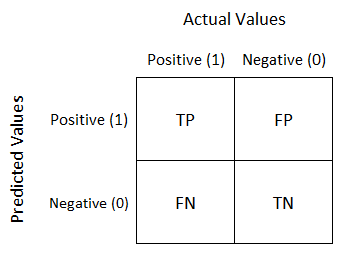
    </div>
    <div style="float:right;width:50%;padding-top:50px">
    <img src="https://miro.medium.com/max/1400/1*UVP_xb4F6J-M-xH3haz5Jw.png">
    </div>
    <div style="clear:both"></div>
    </div>

From the confusion matrix, we can obtain the following indicators.

- **Recall:** Out of all the positive classes, how much we predicted correctly. It should be high as possible.
- **Precision:** Out of all the positive classes we have predicted correctly, how many are actually positive.
- **Accuracy:** Out of all the classes, how much we predicted correctly. It should be high as possible.
- **F1-Score : Combining Precision and Accuracy:** It is the weighted average of Precision and Recall. It takes both <strong>False Positives</strong> and <strong>False Negative </strong> into account.

In [207]:
# Calculate the elements of the confusion matrix
TN = dtPredictions.filter('prediction = 0 AND label = 0').count()
TP = dtPredictions.filter('prediction = 1 AND label = 1').count()
FN = dtPredictions.filter('prediction = 0 AND label = 1').count()#WRITE CODE to find the False Negative
FP = dtPredictions.filter('prediction = 1 AND label = 0').count()#WRITE CODE to find the False Positive

# show confusion matrix
dtPredictions.groupBy('label', 'prediction').count().show()
# calculate metrics by the confusion matrix
accuracy = (TP+TN)/(TP+TN+FP+FN)#WRITE CODE : formula to find accuracy
precision = TP/(TP+FP)#WRITE CODE : formula to find precision
recall = TP/(TP+FN)#WRITE CODE : formula to find recall
f1 = 2/((1/recall) + (1/precision))#WRITE CODE : formula to find F1-score

#Display the various metrics calculated above
print("Accuracy: " + str(accuracy))
print("Precision: " + str(precision))
print("Recall: " + str(recall))
print("F-1 Score: " + str(f1))

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0|  253|
|  0.0|       1.0|   80|
|  1.0|       0.0|  265|
|  0.0|       0.0|  505|
+-----+----------+-----+

Accuracy: 0.6872166817769719
Precision: 0.7597597597597597
Recall: 0.48841698841698844
F-1 Score: 0.5945945945945946


In [208]:
def compute_metrics(predictions):
    #WRITE CODE: to calculate accuracy,precision,recall and f1 based on above example
    TN = predictions.filter('prediction = 0 AND label = 0').count()
    TP = predictions.filter('prediction = 1 AND label = 1').count()
    FN = predictions.filter('prediction = 0 AND label = 1').count()#WRITE CODE to find the False Negative
    FP = predictions.filter('prediction = 1 AND label = 0').count()#WRITE CODE to find the False Positive

    # show confusion matrix
    dtPredictions.groupBy('label', 'prediction').count().show()
    # calculate metrics by the confusion matrix
    accuracy = (TP+TN)/(TP+TN+FP+FN)#WRITE CODE : formula to find accuracy
    precision = TP/(TP+FP)#WRITE CODE : formula to find precision
    recall = TP/(TP+FN)#WRITE CODE : formula to find recall
    f1 = 2/((1/recall) + (1/precision))#WRITE CODE : formula to find F1-score
    return accuracy,precision,recall,f1    

In [209]:
#Print the accuracy,precision,recall and f1 scores for each Classification algorithm, using the function created
print("Decision Tree: " +str(compute_metrics(dtPredictions)))
print("Random Forest Classifier: " + str(compute_metrics(predictions)))
print("Logistic Regression: " + str(compute_metrics(predicted_data)))

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0|  253|
|  0.0|       1.0|   80|
|  1.0|       0.0|  265|
|  0.0|       0.0|  505|
+-----+----------+-----+

Decision Tree: (0.6872166817769719, 0.7597597597597597, 0.48841698841698844, 0.5945945945945946)
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0|  253|
|  0.0|       1.0|   80|
|  1.0|       0.0|  265|
|  0.0|       0.0|  505|
+-----+----------+-----+

Random Forest Classifier: (0.6990027198549411, 0.7162790697674418, 0.5945945945945946, 0.649789029535865)
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0|  253|
|  0.0|       1.0|   80|
|  1.0|       0.0|  265|
|  0.0|       0.0|  505|
+-----+----------+-----+

Logistic Regression: (0.6727107887579329, 0.6740576496674058, 0.5868725868725869, 0.6274509803921569)


In [212]:
import matplotlib.pyplot as plt
def plot_metrics(x,y):
    plt.style.use('ggplot')   
    x_pos = [i for i, _ in enumerate(x)]
    plt.bar(x_pos, y, color='blue')
    plt.xlabel("Classification Algorithms")
    plt.ylabel("AUC")
    plt.title("Accuracy of ML Classification Algorithms")
    plt.xticks(x_pos, x)
    plt.show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0|  253|
|  0.0|       1.0|   80|
|  1.0|       0.0|  265|
|  0.0|       0.0|  505|
+-----+----------+-----+

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0|  253|
|  0.0|       1.0|   80|
|  1.0|       0.0|  265|
|  0.0|       0.0|  505|
+-----+----------+-----+

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0|  253|
|  0.0|       1.0|   80|
|  1.0|       0.0|  265|
|  0.0|       0.0|  505|
+-----+----------+-----+



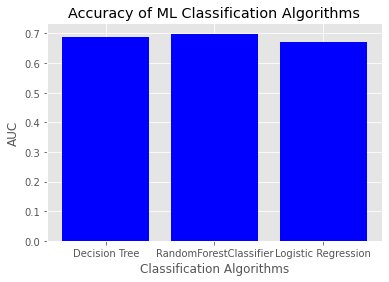

In [213]:
accuracy_list = list()
accuracy,precision,recall,f1 = compute_metrics(dtPredictions)
accuracy_list.append(accuracy)
accuracy,precision,recall,f1 = compute_metrics(predictions)
accuracy_list.append(accuracy)
accuracy,precision,recall,f1 = compute_metrics(predicted_data)
accuracy_list.append(accuracy)
plot_metrics(['Decision Tree','RandomForestClassifier','Logistic Regression'],accuracy_list)

#### Area Under the Curve (AUC-ROC) <a class="anchor" name="roc"></a>
When we need to check or visualize the performance of the multi - class classification problem, we use AUC (Area Under The Curve) ROC (Receiver Operating Characteristics) curve. It is one of the most important evaluation metrics for checking any classification model’s performance.

<br/><br/>

<div style="width:40%;float:left;text-align:left;">
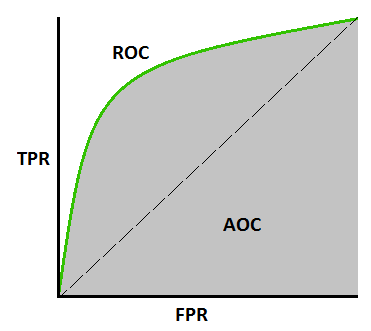
    </div><div style="width:60%;float:right;text-align:justify">
AUC - ROC curve is a performance measurement for classification problem at various thresholds settings. ROC is a probability curve and AUC represents degree or measure of separability. It tells how much model is capable of distinguishing between classes. Higher the AUC, better the model is at predicting 0s as 0s and 1s as 1s.
    
In the example below, we are using Spark's <code>BinaryClassificationEvaluator</code> to compute the AUC-ROC curve.
   </div>
   <div style="clear:both"></div> 

##### Binary Classification Metrics <a class="anchor" name="bce"></a> 
Now let's evaluate the model using BinaryClassificationMetrics class in Spark ML. BinaryClassificationMetrics by default uses areaUnderROC as the performance metric.
<a href="https://spark.apache.org/docs/latest/mllib-evaluation-metrics.html#binary-classification" target='_BLANK'>Read More</a>

In [214]:
# Use BinaryClassificationEvaluator to evaluate a model
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Evaluate model Decision Tree
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
auc_dt = evaluator.evaluate(dtPredictions)
print(auc_dt)
print(evaluator.getMetricName())

0.5134491634491634
areaUnderROC


In [215]:
#WRITE CODE : area under curve for Random Forest
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
auc_rf = evaluator.evaluate(predictions)
print(auc_rf)
print(evaluator.getMetricName())

0.7475200475200469
areaUnderROC


In [216]:
#WRITE CODE : area under curve for Logistic Regression
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
auc_lr = evaluator.evaluate(predicted_data)
print(auc_lr)
print(evaluator.getMetricName())

0.7062700062700059
areaUnderROC


### Visualizing AUC-ROC <a class="anchor" name="roc-viz"></a> 
We can easily visualize the ROC curve for <strong>Logistic Regression</strong> using the <code>BinaryClassificationEvaluator</code>. The example below shows how to plot it using matplotlib.


Area Under ROC: 0.7062700062700059


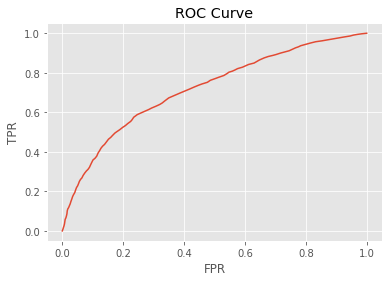

In [220]:
import matplotlib.pyplot as plt

print("Area Under ROC: " + str(evaluator.evaluate(predicted_data, {evaluator.metricName: "areaUnderROC"})))

# Plot ROC curve
trainingSummary = model.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.title('ROC Curve')
plt.show()

##### Getting the thresholds
We can simply use numpy <code>linspace</code> to get a list of thresholds.

In [221]:
import numpy as np
print(np.linspace(0, 1, 100))

[0.         0.01010101 0.02020202 0.03030303 0.04040404 0.05050505
 0.06060606 0.07070707 0.08080808 0.09090909 0.1010101  0.11111111
 0.12121212 0.13131313 0.14141414 0.15151515 0.16161616 0.17171717
 0.18181818 0.19191919 0.2020202  0.21212121 0.22222222 0.23232323
 0.24242424 0.25252525 0.26262626 0.27272727 0.28282828 0.29292929
 0.3030303  0.31313131 0.32323232 0.33333333 0.34343434 0.35353535
 0.36363636 0.37373737 0.38383838 0.39393939 0.4040404  0.41414141
 0.42424242 0.43434343 0.44444444 0.45454545 0.46464646 0.47474747
 0.48484848 0.49494949 0.50505051 0.51515152 0.52525253 0.53535354
 0.54545455 0.55555556 0.56565657 0.57575758 0.58585859 0.5959596
 0.60606061 0.61616162 0.62626263 0.63636364 0.64646465 0.65656566
 0.66666667 0.67676768 0.68686869 0.6969697  0.70707071 0.71717172
 0.72727273 0.73737374 0.74747475 0.75757576 0.76767677 0.77777778
 0.78787879 0.7979798  0.80808081 0.81818182 0.82828283 0.83838384
 0.84848485 0.85858586 0.86868687 0.87878788 0.88888889 0.89898

If we look at the <code>probability</code> column of the predictions, we will see it is an <code>Array</code> with two probability values, the first one for negative class and the second one for positive class. Now we can consider the <strong>probability for positive class</strong> to decide which value is <strong>positive</strong> and which value is <strong>negative</strong>

For example, if our threshold is 0.7, we can say <strong>if the positive probability is greater than 0.7, it is a positive prediction else it is a negative prediction</strong>. 

Here is an example for the Decision Tree Predictions.

In [222]:
#User Defined Function to split the probabilities into two columns
import pyspark.sql.functions as F
import pyspark.sql.types as T
to_array = F.udf(lambda v: v.toArray().tolist(), T.ArrayType(T.FloatType()))

In [223]:
#Splitting the probability to 2 parts using the UDF
df = dtPredictions.withColumn('probability', to_array('probability'))

In [224]:
#A new df which contains the probabilites in separate columns
prob_df = df.select(df.probability[0].alias('negative_prob'),df.probability[1].alias('positive_prob'),'label')

Now, we have extracted the probabilities for positive and negative class. Now we need to create our own <code>prediction</code> column based on a threshold we are provided.

In [225]:
#Here based on the threshold, the prediction column is computed
threshold=0.7
prob_df.withColumn('prediction',F.when(prob_df.positive_prob > threshold,1).otherwise(0))

DataFrame[negative_prob: float, positive_prob: float, label: double, prediction: int]

Now we can create the confusion metrics based on the new predicted class. Let's create a function to do that. The function returns the TN,TP,FN and FP values.

In [226]:
def confusion_matrix(predictions):
     # Calculate the elements of the confusion matrix
    TN = predictions.filter('prediction = 0 AND label = 0').count()
    TP = predictions.filter('prediction = 1 AND label = 1').count()
    FN = predictions.filter('prediction = 0 AND label = 1').count()
    FP = predictions.filter('prediction = 1 AND label = 0').count()
    return TP,TN,FP,FN

In [227]:
#TESTING 
#for threshold 0.7, lets calculate the TN,TP,FN,FP from confusion matrix
threshold=0.7
test_df=prob_df.withColumn('prediction',F.when(prob_df.positive_prob > threshold,1).otherwise(0))
tp,tn,fp,fn = confusion_matrix(prob_df)  
tpr = tp/(tp+fn)
fpr = fp/(fp+tn)
print('TPR:',tpr,'FPR:',fpr)

TPR: 0.48841698841698844 FPR: 0.13675213675213677
